## This will be used to analyze the reversal data

In [1]:
import pandas as pd 

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
%config Completer.use_jedi = False


In [2]:
output_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC'

In [3]:
# get difumo's labels
labels = pd.read_csv('/gpfs/gibbs/pi/levy_ifat/Or/DiFuMo_atlas/256/labels_256_dictionary.csv')
labels.iloc[167]
#labels['Difumo_names']=='Ventromedial Prefrontal'

Component                          168
Difumo_names      Hippocampus anterior
Yeo_networks7         No network found
Yeo_networks17                DefaultC
GM                            0.640856
WM                            0.312741
CSF                           0.046405
Name: 167, dtype: object

In [4]:
tsFiles =  glob.glob((os.path.join(output_dir, 'timeSeries','sub*.npy')))
ts_total57 = [] # the 570 timeseries
ts_total55 = [] # the 555
ts_total51 = [] # the 514
sub51 = []
sub55 = {}
sub57 = []
for f in tsFiles:
    ts = np.load(f)
    sub = os.path.basename(f).split('_')[0]
    if ts.shape[0] > 545:
        # z-score
        t = ts[:548]
        tz = scipy.stats.zscore(t, axis=0)
        # append
        ts_total55.append(tz)
        sub55[sub] = tz # make it a dictionary

    else:
        ts_total51.append(ts[2:])
        sub51.append(sub)
            

In [5]:
# remove items and subejcts
for i in range(len(ts_total55)):
    if ts_total55[i].shape[0] < 545:
        #print(i)
        #print(ts_total55[i].shape)
        sub55.pop(i)
        ts_total55.pop(i)
        
        
print(np.array(ts_total57).shape)
print(np.array(ts_total51).shape)
print(np.array(ts_total55).shape)        

(0,)
(24,)
(89, 548, 256)


/tmp/ipykernel_24592/3254487080.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(ts_total51).shape)


In [6]:
len(sub55)

89

In [7]:
# now lets take the actual conditions
# we have two different sets
stimList = pd.read_csv('Behavioral/StimList.csv')
stimOnset = np.array(stimList.Time)/2 # divide by two as tr=2

# take only the first part of experiment (first 30 stimuli)
stimFirst = stimOnset[0:30]

In [72]:
roi1 = 20 # amygdala
roi2 = 94 #167 - Antrior hippocampus, 42- VMPFC, 94 - hippocampus posterior
length = 8 # number of trs
array = sub55#ts_total55
fmriCoupling = {} # create a dictionary of Amygdala posterior hippomcapus coupling
for sub in array.keys():
    #print(sub)
    #print(array[sub])
    dist = []
    for i in stimFirst:
        
        i = int(i)
        #print(i)
        a = array[sub][i:i+length,roi1] 
        b = array[sub][i:i+length,roi2]
        dist.append(scipy.stats.spearmanr(a,b)[0])
    fmriCoupling[sub] = dist

# Grab SCR data

In [73]:
scr = pd.read_csv('firstSCRpart.csv')
scr = scr[['Event.Nr', 'CDA.AmpSum', 'sub']] #  grab relevant columns

In [74]:
scr_subs = scr['sub'].unique()
len(scr_subs)

101

In [75]:
fmriSubs = fmriCoupling.keys()
len(fmriSubs)
scr_fmriCoup = {}
ampSums = [] # grab array of all, just for plotting porpuses
fmriSums = [] # grab fmri coupling for plotting
for sub in fmriSubs:
    #print(sub)
    sInt =  sub.split('-')[1] #subject as integer
    #print(sInt)
    #try:
    ampSum = scr['CDA.AmpSum'][scr['sub']==int(sInt)].values
    fmri = fmriCoupling[sub]
    if len(ampSum)==0: # check if empty data
        print(f'Subject {sub} has no data')
    else:

        #plt.plot(ampSum, color='red')
        #plt.plot(fmri, color='blue')
        #plt.show()
        scr_fmriCoup[sub] = scipy.stats.pearsonr(ampSum, fmri)
        ampSums.append(ampSum)
        fmriSums.append(fmri)
    #except:
     #   print(f'Subject {sub} doesnt have data')

Subject sub-143 has no data
Subject sub-188 has no data
Subject sub-190 has no data
Subject sub-194 has no data
Subject sub-135 has no data
Subject sub-161 has no data
Subject sub-140 has no data
Subject sub-025 has no data
Subject sub-137 has no data
Subject sub-1207 has no data
Subject sub-148 has no data
Subject sub-147 has no data
Subject sub-195 has no data


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='variable', ylabel='value'>

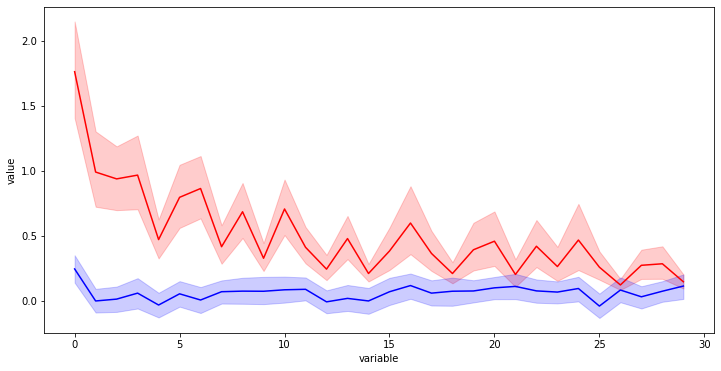

In [76]:
# plot amplitude sum and fmri coupling
d = pd.DataFrame(np.array(ampSums)) # scr 
e = pd.DataFrame(np.array(fmriSums)) # fmri
d = pd.melt(d)
e = pd.melt(e)

#%matplotlib notebook
plt.figure(figsize=[12,6])
sns.lineplot('variable','value', data=d, color='red')
sns.lineplot('variable','value', data=e, color = 'blue')

In [77]:
len(scr_fmriCoup) # 76 participants
scrDf = pd.DataFrame(scr_fmriCoup).T
scrDf.columns = ['r','p']
scrDf.describe()


,r,p
count,76.000000,76.000000
mean,0.063593,0.440544
std,0.206794,0.297679
min,-0.371522,0.002287
25%,-0.094095,0.173168
50%,0.070615,0.424034
75%,0.196680,0.701591
max,0.535602,0.984508


In [78]:
pg.ttest(x=scrDf['r'], y=0) # test if correlation is different than zero

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.68088,75,two-sided,0.009024,"[0.02, 0.11]",0.307518,3.489,0.753786


## Correlation between amygdala-hippocampus and SCR different than zero

- Correlation between anterior hippocampus and amygdala and scr is different than zero
- Correlation between posterior hippocampus-amygdala and scr is also different than zero
- Correlation between amygdala-vmPFC and scr is zero

# Test Different Groups

In [64]:
dfGroups = pd.read_csv('Behavioral/SubGroupLists.csv', dtype={'Sub': 'string'})
dfGroups = dfGroups[['Sub','group', 'Eprime']]
for i in dfGroups.iterrows():
    dfGroups.at[i[0], 'Sub'] = "sub-" + str(i[1].Sub)


In [65]:
dfBoth = dfGroups.merge(scrDf, left_on='Sub', right_on=None, right_index=True)

<AxesSubplot:xlabel='group', ylabel='r'>

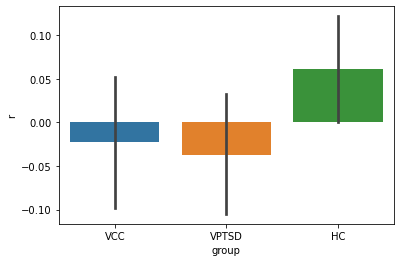

In [66]:
sns.barplot(x='group', y='r', data=dfBoth)

In [67]:
pg.anova(dfBoth, dv='r', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,66,1.862774,0.163311,0.053432


In [68]:
glm = smf.ols('r ~ group', data=dfBoth)
model1 = glm.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.863
Date:                Mon, 08 Nov 2021   Prob (F-statistic):              0.163
Time:                        07:22:14   Log-Likelihood:                 23.668
No. Observations:                  69   AIC:                            -41.34
Df Residuals:                      66   BIC:                            -34.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0612      0.040      1.

### Group differences
- vmPFC shows no difference between groups (although healthy controls are a bit higher)
- anterior hippocampus also shows no differences between groups
- posterior - no group difference as well

# Remove first two trials
- Just to make sure it's not mainly the habituation of SCR

In [91]:
fmriSubs = fmriCoupling.keys()
len(fmriSubs)
scr_fmriCoup = {}
ampSums = [] # grab array of all, just for plotting porpuses
fmriSums = [] # grab fmri coupling for plotting
for sub in fmriSubs:
    #print(sub)
    sInt =  sub.split('-')[1] #subject as integer
    #print(sInt)
    #try:
    ampSum = scr['CDA.AmpSum'][scr['sub']==int(sInt)].values
    fmri = fmriCoupling[sub]
    if len(ampSum)==0: # check if empty data
        print(f'Subject {sub} has no data')
    else:

        #plt.plot(ampSum, color='red')
        #plt.plot(fmri, color='blue')
        #plt.show()
        scr_fmriCoup[sub] = scipy.stats.pearsonr(ampSum[2:-5], fmri[2:-5])
        ampSums.append(ampSum)
        fmriSums.append(fmri)

Subject sub-143 has no data
Subject sub-188 has no data
Subject sub-190 has no data
Subject sub-194 has no data
Subject sub-135 has no data
Subject sub-161 has no data
Subject sub-140 has no data
Subject sub-025 has no data
Subject sub-137 has no data
Subject sub-1207 has no data
Subject sub-148 has no data
Subject sub-147 has no data
Subject sub-195 has no data


In [92]:
len(scr_fmriCoup) # 76 participants
scrDf = pd.DataFrame(scr_fmriCoup).T
scrDf.columns = ['r','p']
scrDf.describe()

,r,p
count,76.000000,76.000000
mean,0.049195,0.465204
std,0.212281,0.272721
min,-0.392217,0.010589
25%,-0.117718,0.245754
50%,0.064508,0.468144
75%,0.230535,0.662119
max,0.522183,0.991257


In [93]:
pg.ttest(x=scrDf['r'], y=0) # test if correlation is different than zero

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.020296,75,two-sided,0.046924,"[0.0, 0.1]",0.231744,0.862,0.513771
